# Functional API
In this module, we will explore Keras's another model building API called functional API.
Here is the documentation: https://keras.io/getting-started/functional-api-guide/

In `Sequential`, you build a model by adding a layer to the `model` object:

```python
model = Sequential()
model.add(Conv2D(32, 3, input_shape=(32,32,3), activation='relu))
model.add(Cond2D(32, 3))
model.add(Activation('relu'))
...
```
However, in functional API, you pass the featuremap as an input to the layer:   

```python
inputs = Input(shape=(32,32,3))
conv1 = Conv2D(32,3, activation='relu')(inputs)
conv2 = Conv2D(32,3)(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)
...
model = Model(inputs=inputs, outputs=outputs)
```
You may have noticed that the functional API model needs a separate layer for input and output. Input() creates the the input tensor. Model() actually makes a model object from the output tensor. 

An advantage of functional API over Sequential is its flexibility. You can build a model architecture that has parallel paths or merging layers.

```python
...
conv1 = Conv2D(32,3,activation='relu')(conv0)
conv2 = Conv2D(32,5,activation='relu')(conv0)
...
```
Above example shows that the feature map from conv0 is split into two paths and are passed to conv1, and conv2   
```
         ____ conv1 (3x3)
        /     
conv0---     
        \____ conv2 (5x5)
```         

# Make an inception module from scratch
In the following exercise, you will make an inception module.
You'll need some info from [this paper](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=0ahUKEwiC3sb8krbaAhWK5oMKHUroAlYQFggpMAA&url=https%3A%2F%2Farxiv.org%2Fpdf%2F1409.4842&usg=AOvVaw3v1ON5KCX99lZhuMLtNROq) to complete following.

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print('Train Images shape: {} size: {:,}'.format(X_train.shape, X_train.size))

Train Images shape: (60000, 28, 28) size: 47,040,000


In [2]:
import time
import numpy
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras import backend as K
from keras.optimizers import Adam

K.set_image_dim_ordering( 'tf' )

# fix random seed for reproducibility
seed = 123
numpy.random.seed(seed)
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][width][height][channel]
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype( 'float32' )
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype( 'float32' )
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
num_classes = y_test.shape[1]
print(y_test.shape)
print('Train Images shape: {} size: {:,}'.format(X_train.shape, X_train.size))

(10000, 10)
Train Images shape: (60000, 28, 28, 1) size: 47,040,000


In [2]:
## YOUR TURN
## make an inception module as shown in the paper Fig 2(a), the naive version 
## each conv takes 32 filters, and has same padding, relu activation
## Hint: use the Concatenate as in the import layers above
## Hint: MaxPoolng2D needs 1x1 strides and same padding to match the spatial dimension

def inception1(x, n = 32):
    p1 = Conv2D(n, 1, activation ='relu', padding='same')(x)
    p2 = Conv2D(n, 3, activation ='relu', padding='same')(x)
    p3 = Conv2D(n, 5, activation ='relu', padding='same')(x)
    p4 = MaxPooling2D((3,3), strides=(1, 1), padding='same')(x)
    c =  Concatenate(axis=-1)([p1,p2,p3,p4])
    return c

In [19]:
## YOUR TURN
## make an inception module as shown in the paper Fig 2(b), which has 1x1 conv layers 
## each conv takes 32 filters, and has same padding
def inception2(x, n = 32):
    p1 = Conv2D(n, 1, activation ='relu', padding='same')(x)
    p2 = Conv2D(n, 1, activation ='relu', padding='same')(x)
    p2 = Conv2D(n, 3, activation ='relu', padding='same')(p2)
    p3 = Conv2D(n, 1, activation ='relu', padding='same')(x)
    p3 = Conv2D(n, 5, activation ='relu', padding='same')(p3)
    p4 = MaxPooling2D((3,3), strides=(1, 1), padding='same')(x)
    p4 = Conv2D(n, 1, activation ='relu', padding='same')(p4)
    c =  Concatenate(axis=-1)([p1,p2,p3,p4])
    return c

In [9]:
## YOUR TURN
## Now, build a model that has this structure:
## input-inception1-maxpool(2x2)-inception1-maxpool(2x2)-dense(128)-output
## print out the model summary
## Hint: input layer needs Input() as imported above
def model1():
    inputs = Input(X_train.shape[1:])
    i1 = inception1(inputs)
    mp1 = MaxPooling2D((2,2))(i1)
    i2 = inception1(mp1)
    mp2 = MaxPooling2D((2,2))(i2) 
    f = Flatten()(mp2)
    d = Dense(128, activation='relu')(f)
    out = Dense(10, activation='softmax')(d)
    model = Model(inputs, out)
    return model

In [10]:
model1 = model1()
model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 28, 28, 32)   64          input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 28, 28, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 28, 28, 32)   832         input_3[0][0]                    
__________________________________________________________________________________________________
max_poolin

In [20]:
## YOUR TURN
## Now, build a model that has this structure:
## input-inception2-maxpool(2x2)-inception2-maxpool(2x2)-dense(128)-output
## name the model variable as model1
## print out the model summary
## Hint: input layer needs Input() as imported above
def model2():
    inputs = Input(X_train.shape[1:])
    i1 = inception2(inputs)
    mp1 = MaxPooling2D((2,2))(i1)
    i2 = inception2(mp1)
    mp2 = MaxPooling2D((2,2))(i2) 
    f = Flatten()(mp2)
    d = Dense(128, activation='relu')(f)
    out = Dense(10, activation='softmax')(d)
    model = Model(inputs, out)
    return model

In [21]:
model2 = model2()
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 28, 28, 32)   64          input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 28, 28, 32)   64          input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_21 (MaxPooling2D) (None, 28, 28, 1)    0           input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_51 

### Q1.
What is the number of parameters from model1()    
1,321,866    
What is the number of parameters from model2()    
890,762   
Explain why and which model is more efficient.    
model2 is more efficient because it uses 1x1 convolution layers to control the depth.   

### Q2. 
Add Adam optimizer with lr=0.001. Train for 50 epochs.
Compare the error rate for two models.

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
 - 7s - loss: 0.2146 - acc: 0.9342 - val_loss: 0.0722 - val_acc: 0.9777
Epoch 2/50
 - 6s - loss: 0.0556 - acc: 0.9829 - val_loss: 0.0641 - val_acc: 0.9813
Epoch 3/50
 - 6s - loss: 0.0379 - acc: 0.9882 - val_loss: 0.0435 - val_acc: 0.9858
Epoch 4/50
 - 6s - loss: 0.0295 - acc: 0.9906 - val_loss: 0.0346 - val_acc: 0.9897
Epoch 5/50
 - 6s - loss: 0.0233 - acc: 0.9926 - val_loss: 0.0444 - val_acc: 0.9863
Epoch 6/50
 - 6s - loss: 0.0172 - acc: 0.9942 - val_loss: 0.0475 - val_acc: 0.9869
Epoch 7/50
 - 6s - loss: 0.0143 - acc: 0.9950 - val_loss: 0.0346 - val_acc: 0.9901
Epoch 8/50
 - 6s - loss: 0.0144 - acc: 0.9950 - val_loss: 0.0620 - val_acc: 0.9818
Epoch 9/50
 - 6s - loss: 0.0098 - acc: 0.9969 - val_loss: 0.0308 - val_acc: 0.9908
Epoch 10/50
 - 6s - loss: 0.0092 - acc: 0.9969 - val_loss: 0.0356 - val_acc: 0.9903
Epoch 11/50
 - 6s - loss: 0.0072 - acc: 0.9977 - val_loss: 0.0393 - val_acc: 0.9898
Epoch 12/50
 - 6s - loss: 0.0066 - 

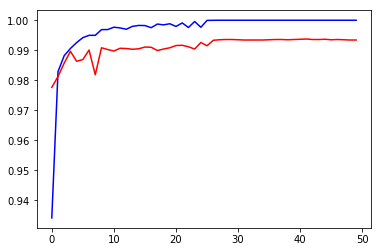

In [13]:
adam = Adam(lr=0.001)
model1.compile(loss= 'categorical_crossentropy' , optimizer= adam , metrics=[ 'accuracy' ])

# Fit the model
t0=time.time()
log1 = model1.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=200, verbose=2)
t1=time.time()
print(t1-t0," seconds")

# Final evaluation of the model
scores = model1.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(log1.history['acc'],'b') 
plt.plot(log1.history['val_acc'],'r')
plt.show()

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
 - 11s - loss: 0.2256 - acc: 0.9299 - val_loss: 0.0544 - val_acc: 0.9833
Epoch 2/50
 - 11s - loss: 0.0473 - acc: 0.9858 - val_loss: 0.0417 - val_acc: 0.9872
Epoch 3/50
 - 12s - loss: 0.0318 - acc: 0.9898 - val_loss: 0.0354 - val_acc: 0.9897
Epoch 4/50
 - 12s - loss: 0.0224 - acc: 0.9928 - val_loss: 0.0341 - val_acc: 0.9896
Epoch 5/50
 - 12s - loss: 0.0166 - acc: 0.9948 - val_loss: 0.0325 - val_acc: 0.9891
Epoch 6/50
 - 12s - loss: 0.0125 - acc: 0.9960 - val_loss: 0.0330 - val_acc: 0.9903
Epoch 7/50
 - 12s - loss: 0.0102 - acc: 0.9966 - val_loss: 0.0353 - val_acc: 0.9899
Epoch 8/50
 - 11s - loss: 0.0070 - acc: 0.9978 - val_loss: 0.0416 - val_acc: 0.9902
Epoch 9/50
 - 11s - loss: 0.0056 - acc: 0.9981 - val_loss: 0.0512 - val_acc: 0.9884
Epoch 10/50
 - 12s - loss: 0.0073 - acc: 0.9973 - val_loss: 0.0416 - val_acc: 0.9897
Epoch 11/50
 - 11s - loss: 0.0064 - acc: 0.9976 - val_loss: 0.0438 - val_acc: 0.9895
Epoch 12/50
 - 12s - los

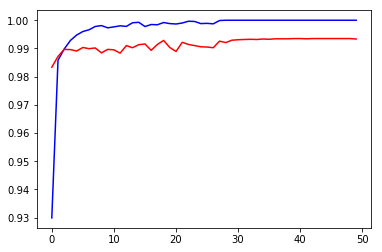

In [22]:
adam = Adam(lr=0.001)
model2.compile(loss= 'categorical_crossentropy' , optimizer= adam , metrics=[ 'accuracy' ])

# Fit the model
t0=time.time()
log2 = model2.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=200, verbose=2)
t1=time.time()
print(t1-t0," seconds")

# Final evaluation of the model
scores2 = model2.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores2[1]*100))

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(log2.history['acc'],'b') 
plt.plot(log2.history['val_acc'],'r')
plt.show()

The model with 1x1 conv takes longer. The performances fluctuate, so it's hard to tell which is better.
Seems the parallel paths (towers) helps when compared to two-layer-deep models we used previously.

### Q3. 
Apply BatchNorm after every conv or dense layers for the inception module 2. 
Compare the performances.

In [26]:
def inception2BN(x, n = 32):
    p1 = Conv2D(n, 1, padding='same')(x)
    p1 = BatchNormalization()(p1)
    p1 = Activation('relu')(p1)
    p2 = Conv2D(n, 1, padding='same')(x)
    p2 = BatchNormalization()(p2)
    p2 = Activation('relu')(p2)
    p2 = Conv2D(n, 3, padding='same')(p2)
    p2 = BatchNormalization()(p2)
    p2 = Activation('relu')(p2)    
    p3 = Conv2D(n, 1, padding='same')(x)
    p3 = BatchNormalization()(p3)
    p3 = Activation('relu')(p3)    
    p3 = Conv2D(n, 5, padding='same')(p3)
    p3 = BatchNormalization()(p3)
    p3 = Activation('relu')(p3)  
    p4 = MaxPooling2D((3,3), strides=(1, 1), padding='same')(x)    
    p4 = Conv2D(n, 1, padding='same')(p4)
    p4 = BatchNormalization()(p4)
    p4 = Activation('relu')(p4)     

    c =  Concatenate(axis=-1)([p1,p2,p3,p4])
    return c

In [27]:
def model3():
    inputs = Input(X_train.shape[1:])
    i1 = inception2BN(inputs)
    mp1 = MaxPooling2D((2,2))(i1)
    i2 = inception2BN(mp1)
    mp2 = MaxPooling2D((2,2))(i2) 
    f = Flatten()(mp2)
    d = Dense(128)(f)
    d = BatchNormalization()(d)
    d = Activation('relu')(d)
    out = Dense(10, activation='softmax')(d)
    model = Model(inputs, out)
    return model

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
 - 19s - loss: 0.1169 - acc: 0.9684 - val_loss: 1.5253 - val_acc: 0.2990
Epoch 2/50
 - 17s - loss: 0.0327 - acc: 0.9914 - val_loss: 0.0736 - val_acc: 0.9794
Epoch 3/50
 - 18s - loss: 0.0176 - acc: 0.9956 - val_loss: 0.0816 - val_acc: 0.9759
Epoch 4/50
 - 18s - loss: 0.0115 - acc: 0.9973 - val_loss: 0.0419 - val_acc: 0.9871
Epoch 5/50
 - 19s - loss: 0.0075 - acc: 0.9983 - val_loss: 0.0453 - val_acc: 0.9864
Epoch 6/50
 - 18s - loss: 0.0068 - acc: 0.9983 - val_loss: 0.0761 - val_acc: 0.9781
Epoch 7/50
 - 18s - loss: 0.0056 - acc: 0.9986 - val_loss: 0.0419 - val_acc: 0.9885
Epoch 8/50
 - 18s - loss: 0.0025 - acc: 0.9996 - val_loss: 0.0403 - val_acc: 0.9878
Epoch 9/50
 - 18s - loss: 0.0022 - acc: 0.9996 - val_loss: 0.0389 - val_acc: 0.9888
Epoch 10/50
 - 18s - loss: 0.0027 - acc: 0.9994 - val_loss: 0.0416 - val_acc: 0.9887
Epoch 11/50
 - 18s - loss: 0.0121 - acc: 0.9964 - val_loss: 0.0645 - val_acc: 0.9811
Epoch 12/50
 - 18s - los

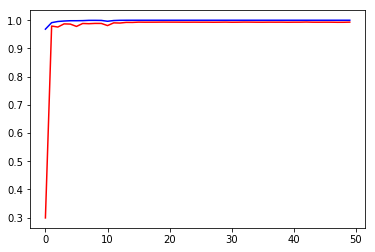

In [28]:
model3 = model3()
adam = Adam(lr=0.001)
model3.compile(loss= 'categorical_crossentropy' , optimizer= adam , metrics=[ 'accuracy' ])

# Fit the model
t0=time.time()
log3 = model3.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=200, verbose=2)
t1=time.time()
print(t1-t0," seconds")

# Final evaluation of the model
scores3 = model3.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores3[1]*100))

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(log3.history['acc'],'b') 
plt.plot(log3.history['val_acc'],'r')
plt.show()

BatchNorm makes it converge faster, and improved the result somewhat.